In [50]:
"""
train_gnn_only.py

Train a GNN autoencoder on spatial dataset A only to test whether
the GNN can learn meaningful latent embeddings for xenium_spatial.

Outputs:
 - gnn_only.pt         (model state_dict)
 - z_spatial_gnn.npy   (learned latent embeddings)
 - gnn_recon_loss.csv  (per-epoch recon loss)
 - embeddings_umap_gnn.png, embeddings_pca_gnn.png (visuals)
"""

import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

In [ ]:
# -------------------------
# Config / Hyperparams
# -------------------------
SPAT_H5AD = "SmallData/xenium_spatial_common_genes.h5ad"  # edit if needed
OUT_DIR = "gnn_only_out"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

K_KNN = 12
LATENT_DIM = 20
HIDDEN_DIM = 516
LR = 5e-3
EPOCHS = 2000
BATCH_SIZE = None  # full-batch; we will perform full-batch gradient steps (typical for GNN autoencoders)
WEIGHT_DECAY = 1e-4
DROPOUT = 0.1
SEED = 42

os.makedirs(OUT_DIR, exist_ok=True)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [52]:
# -------------------------
# Utility: adjacency builder
# -------------------------
def build_adj(coords, k=K_KNN):
    A = kneighbors_graph(coords, n_neighbors=k, mode='connectivity', include_self=True).toarray().astype(float)
    A = (A + A.T) / 2.0
    A += np.eye(A.shape[0])
    deg = A.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg + 1e-8))
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return A_norm.astype(np.float32)

# -------------------------
# GNN model (encoder + decoder)
# -------------------------
class GNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=20, dropout=0.2):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.bn1  = nn.LayerNorm(hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, latent_dim)
        self.dropout = nn.Dropout(dropout)
        self.dec = nn.Sequential(nn.Linear(latent_dim, hidden_dim//2),
                                 nn.ReLU(), nn.Linear(hidden_dim//2, input_dim))
    def forward(self, X, A_norm):
        H = torch.relu(self.bn1(A_norm @ self.lin1(X)))
        H = self.dropout(H)
        Z = A_norm @ self.lin2(H)
        recon = self.dec(Z)
        return recon, Z


In [53]:
# -------------------------
# Load + preprocess spatial data
# -------------------------
print("Loading spatial AnnData:", SPAT_H5AD)
adata = sc.read_h5ad(SPAT_H5AD)

# Preprocessing: normalize total counts per cell and log1p.
# If your saved .h5ad is already normalized, you can skip these two lines.
print("Normalizing data (normalize_total -> log1p)...")
adata_proc = adata.copy()
sc.pp.normalize_total(adata_proc, target_sum=1e4)
sc.pp.log1p(adata_proc)

# Convert to dense numpy array (2k subset should be small)
X = adata_proc.X.toarray() if hasattr(adata_proc.X, "toarray") else np.asarray(adata_proc.X)

# per-gene z-score (columns)
gene_mean = X.mean(axis=0, keepdims=True)
gene_std  = X.std(axis=0, keepdims=True) + 1e-6
X_z = (X - gene_mean) / gene_std

X = X_z.astype(np.float32)
N, G = X.shape
print(f"Spatial data shape: N={N}, G={G}")

Loading spatial AnnData: SmallData/xenium_spatial_common_genes.h5ad
Normalizing data (normalize_total -> log1p)...
Spatial data shape: N=2000, G=308


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


In [54]:
coords = adata_proc.obsm.get("spatial", None)
if coords is None:
    raise RuntimeError("No spatial coordinates found in adata.obsm['spatial']")

# Build adjacency
print(f"Building kNN adjacency (k={K_KNN})...")
A_norm = build_adj(coords, k=K_KNN)
A_norm_t = torch.tensor(A_norm, dtype=torch.float32, device=DEVICE)

# Tensors
X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)

Building kNN adjacency (k=12)...


In [55]:
# -------------------------
# Instantiate model + optimizer + loss
# -------------------------
model = GNN_AE(input_dim=G, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, dropout=DROPOUT).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
mse = nn.MSELoss(reduction='mean')

# -------------------------
# Training (full-batch)
# -------------------------
print("Training GNN autoencoder (full-batch) on spatial data only...")
recon_losses = []
for ep in range(1, EPOCHS+1):
    model.train()
    opt.zero_grad()
    recon, z = model(X_t, A_norm_t)  # full-batch forward
    loss = mse(recon, X_t)
    loss.backward()
    opt.step()

    recon_losses.append(loss.item())
    if ep % max(1, EPOCHS//10) == 0 or ep == 1:
        print(f"Epoch {ep:03d}/{EPOCHS} | recon_loss = {loss.item():.6f}")

# Save loss curve
np.savetxt(os.path.join(OUT_DIR, "gnn_recon_loss.csv"), np.array(recon_losses), delimiter=",")


Training GNN autoencoder (full-batch) on spatial data only...
Epoch 001/3000 | recon_loss = 1.015120
Epoch 300/3000 | recon_loss = 0.704918
Epoch 600/3000 | recon_loss = 0.667142
Epoch 900/3000 | recon_loss = 0.656145
Epoch 1200/3000 | recon_loss = 0.645580
Epoch 1500/3000 | recon_loss = 0.646172
Epoch 1800/3000 | recon_loss = 0.640408
Epoch 2100/3000 | recon_loss = 0.642420
Epoch 2400/3000 | recon_loss = 0.638238
Epoch 2700/3000 | recon_loss = 0.630799
Epoch 3000/3000 | recon_loss = 0.630381


In [56]:
# -------------------------
# Save final model & embeddings
# -------------------------
print("Saving model and embeddings...")
torch.save(model.state_dict(), os.path.join(OUT_DIR, "gnn_only.pt"))

model.eval()
with torch.no_grad():
    _, z_final = model(X_t, A_norm_t)
z_np = z_final.cpu().numpy()
np.save(os.path.join(OUT_DIR, "z_spatial_gnn.npy"), z_np)
print(f"Saved embeddings shape: {z_np.shape}")

Saving model and embeddings...
Saved embeddings shape: (2000, 20)


Using label column for coloring: broad_cell_type
Found 8 unique labels


/var/folders/b3/hhpkbnjn3tsgdz2s3hjt3rdw0000gn/T/ipykernel_77455/1741640282.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")  # tab20 has 20 colors
/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


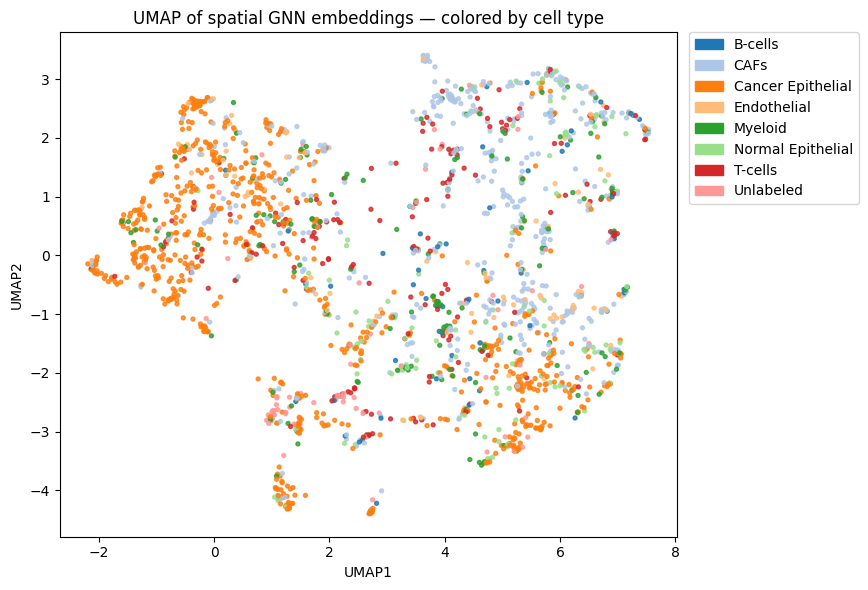

In [57]:
# -------------------------
# Plot embeddings colored by cell type (from adata_proc.obs)
# -------------------------
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Choose candidate label columns and detect one present
candidate_label_cols = ["broad_cell_type", "cell_type", "celltype", "annotation", "label"]
label_col = next((c for c in candidate_label_cols if c in adata_proc.obs.columns), None)
if label_col is None:
    raise RuntimeError("No label column found in adata_proc.obs. Add one of: " + ", ".join(candidate_label_cols))

print("Using label column for coloring:", label_col)
labels = adata_proc.obs[label_col].astype(str).values
unique_labels, inv = np.unique(labels, return_inverse=True)
n_labels = len(unique_labels)
print(f"Found {n_labels} unique labels")

# Choose categorical colormap and assign colors
cmap = plt.cm.get_cmap("tab20")  # tab20 has 20 colors
# If more than 20 labels, we'll cycle through the cmap
colors = [cmap(i % 20) for i in range(n_labels)]
point_colors = [colors[i] for i in inv]



# UMAP of embeddings
Z = z_np
reducer = umap.UMAP(n_components=2, random_state=SEED)
Zu = reducer.fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Zu[:,0], Zu[:,1], c=point_colors, s=8, alpha=0.8)
plt.title("UMAP of spatial GNN embeddings — colored by cell type")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()

handles = [Patch(color=colors[i], label=unique_labels[i]) for i in range(n_labels)]
if n_labels <= 10:
    plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
else:
    plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., ncol=1, fontsize="small")
plt.savefig(os.path.join(OUT_DIR, "embeddings_umap_gnn_by_label.png"), dpi=180, bbox_inches="tight")
plt.show()